# Exploration and Comparison of Transformers for Image Classification

## Fine-tuning using Data-efficient image Transformer (DeiT)

Fine-tuning is an experiment that involves training the entire model on the new task. All of model's parameters are end-to-end fine-tuned on the provided dataset.

The resulting model's performance is the measured on the test split with accuracy metric.

### Data-efficient image Transformer (DeiT)

Distilled data-efficient Image Transformer (DeiT) model pre-trained and fine-tuned on ImageNet-1k (1 million images, 1,000 classes) at resolution 224x224. It was first introduced in the paper *Training data-efficient image transformers & distillation through attention by Touvron et al.*

https://arxiv.org/abs/2012.12877

### Prerequisites

Load necessary packages.

In [2]:
import os
os.chdir('../../')

import torch

import pandas as pd

from datasets import load_dataset

from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *

from utils.config import Config
from utils.train_utils import *
from utils.models_utils import *
from utils.visualization_utils import *
from utils.data_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe MIG 2g.20gb
VRAM: 19.50 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load DeiT image processor used for image pre-processing.

In [5]:
processor = get_backbone_processor(model_names['DeiT'])

Print the pre-processing operations done by the processor.

In [6]:
processor

DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

### Data Preprocessing

Load each dataset and its splits.

Processor is automatically applied to each image.

#### RESISC45

In [7]:
resisc45 = load_dataset('timm/resisc45')
clean_labels(resisc45, name='resisc45')
resisc45_train = ImageDataset(
    dataset=resisc45['train'],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45['validation'],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45['test'],
    processor=processor,
)

#### Food-101

In [8]:
food101 = load_dataset('ethz/food101')
clean_labels(food101, name='food101')
food101_train = ImageDataset(
    dataset=food101['train'],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101['validation'],
    processor=processor,
)

#### FER2013

In [9]:
fer2013 = load_dataset('AutumnQiu/fer2013')
clean_labels(fer2013, name='fer2013')
fer2013_train = ImageDataset(
    dataset=fer2013['train'],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013['valid'],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013['test'],
    processor=processor,
)

#### PCam

In [10]:
pcam = load_dataset('zacharielegault/PatchCamelyon')
clean_labels(pcam, name='pcam')
pcam_train = ImageDataset(
    dataset=pcam['train'],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam['validation'],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam['test'],
    processor=processor,
)

#### SUN397

In [11]:
sun397 = load_dataset('dpdl-benchmark/sun397')
clean_labels(sun397, name='sun397')
sun397_train = ImageDataset(
    dataset=sun397['train'],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397['validation'],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397['test'],
    processor=processor,
)

#### DTD

In [12]:
dtd = load_dataset('tanganke/dtd')
clean_labels(dtd, name='dtd')
dtd_train = ImageDataset(
    dataset=dtd['train'],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd['test'],
    processor=processor,
)

### Config

Create a config for experiments and print its settings.

In [13]:
from torch.optim import AdamW

config = Config(
    num_epochs=10, 
    lr=2e-5,
    optimizer=AdamW,
    weight_decay=1e-2
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 8,
 'lr': 2e-05,
 'num_epochs': 10,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.01}

Create empty array to store dataset accuracies for each experiment.

In [14]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Fine-tuning


Train the entire model and all of its parameters on a new dataset.

Teacher model (RegNet) is trained using the same configuration.

#### RESISC45

In [15]:
teacher_resisc45 = Backbone(model_names['RegNet'], num_classes=len(resisc45_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([45, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
get_model_params(teacher_resisc45)

Parameters: 80.70M


In [17]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    teacher_resisc45,
    resisc45_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 2363/2363 [05:40<00:00,  6.95it/s]


Epochs: 1/10 | train_loss: 0.8368 | train_acc: 0.7815


100%|██████████| 2363/2363 [05:37<00:00,  7.01it/s]


Epochs: 2/10 | train_loss: 0.2255 | train_acc: 0.9329


100%|██████████| 2363/2363 [05:39<00:00,  6.97it/s]


Epochs: 3/10 | train_loss: 0.1115 | train_acc: 0.9679


100%|██████████| 2363/2363 [05:40<00:00,  6.94it/s]


Epochs: 4/10 | train_loss: 0.0823 | train_acc: 0.9755


100%|██████████| 2363/2363 [05:39<00:00,  6.96it/s]


Epochs: 5/10 | train_loss: 0.0614 | train_acc: 0.9819


100%|██████████| 2363/2363 [05:41<00:00,  6.91it/s]


Epochs: 6/10 | train_loss: 0.0500 | train_acc: 0.9853


100%|██████████| 2363/2363 [05:40<00:00,  6.93it/s]


Epochs: 7/10 | train_loss: 0.0412 | train_acc: 0.9882


100%|██████████| 2363/2363 [05:40<00:00,  6.95it/s]


Epochs: 8/10 | train_loss: 0.0372 | train_acc: 0.9886


100%|██████████| 2363/2363 [05:41<00:00,  6.92it/s]


Epochs: 9/10 | train_loss: 0.0356 | train_acc: 0.9895


100%|██████████| 2363/2363 [05:39<00:00,  6.95it/s]

Epochs: 10/10 | train_loss: 0.0354 | train_acc: 0.9901


In [18]:
deit_resisc45 = Backbone(model_names['DeiT'], num_classes=len(resisc45_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
get_model_params(deit_resisc45)

Parameters: 85.87M


In [20]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = train_model(
    deit_resisc45,
    resisc45_train,
    config,
    'deit',
    use_val=False,
    fine_tune=True,
    with_distillation=True,
    teacher=teacher_resisc45,
)

100%|██████████| 2363/2363 [04:49<00:00,  8.17it/s]


Epochs: 1/10 | train_loss: 0.6137 | train_acc: 0.8541


100%|██████████| 2363/2363 [04:51<00:00,  8.10it/s]


Epochs: 2/10 | train_loss: 0.0954 | train_acc: 0.9746


100%|██████████| 2363/2363 [04:49<00:00,  8.16it/s]


Epochs: 3/10 | train_loss: 0.0374 | train_acc: 0.9918


100%|██████████| 2363/2363 [04:51<00:00,  8.11it/s]


Epochs: 4/10 | train_loss: 0.0279 | train_acc: 0.9931


100%|██████████| 2363/2363 [04:50<00:00,  8.13it/s]


Epochs: 5/10 | train_loss: 0.0297 | train_acc: 0.9928


100%|██████████| 2363/2363 [04:50<00:00,  8.13it/s]


Epochs: 6/10 | train_loss: 0.0187 | train_acc: 0.9950


100%|██████████| 2363/2363 [04:50<00:00,  8.15it/s]


Epochs: 7/10 | train_loss: 0.0181 | train_acc: 0.9959


100%|██████████| 2363/2363 [04:50<00:00,  8.13it/s]


Epochs: 8/10 | train_loss: 0.0217 | train_acc: 0.9945


100%|██████████| 2363/2363 [04:51<00:00,  8.11it/s]


Epochs: 9/10 | train_loss: 0.0158 | train_acc: 0.9962


100%|██████████| 2363/2363 [04:49<00:00,  8.18it/s]

Epochs: 10/10 | train_loss: 0.0169 | train_acc: 0.9957


In [21]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    deit_resisc45,
    resisc45_test,
    config
)

100%|██████████| 788/788 [00:25<00:00, 30.91it/s]

test_loss: 0.2615 | test_acc: 0.9314


In [22]:
resisc45_accs.append(resisc45_acc)

In [23]:
get_top_5_accuracies(resisc45_per_class_acc)

[('rectangular farmland', 1.0),
 ('chaparral', 0.9924242424242424),
 ('snowberg', 0.9874213836477987),
 ('tennis court', 0.9861111111111112),
 ('harbor', 0.9859154929577465)]

In [24]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('terrace', 0.7401574803149606),
 ('palace', 0.7785714285714286),
 ('golf course', 0.7868852459016393),
 ('meadow', 0.8384615384615385),
 ('wetland', 0.847457627118644)]

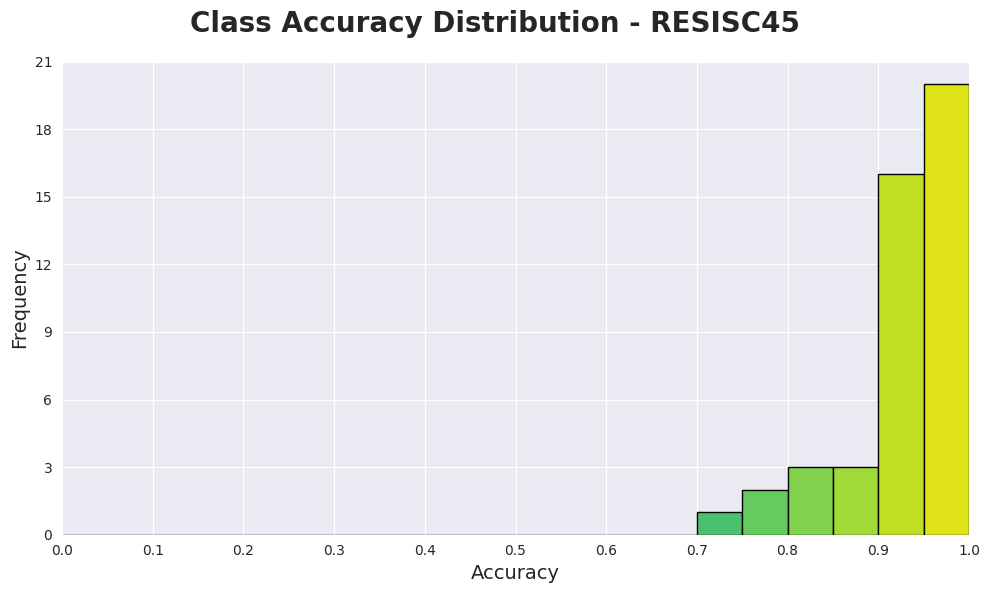

In [25]:
plot_per_class_accuracies(
    resisc45_per_class_acc,
    'RESISC45',
    num_bins=20
)

#### Food-101

In [26]:
teacher_food101 = Backbone(model_names['RegNet'], num_classes=len(food101_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([101, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
get_model_params(teacher_food101)

Parameters: 80.87M


In [28]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    teacher_food101,
    food101_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=True,
)

 90%|█████████ | 8546/9469 [24:36<02:36,  5.92it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 9469/9469 [27:13<00:00,  5.80it/s]


Epochs: 1/10 | train_loss: 1.4701 | train_acc: 0.6381


100%|██████████| 9469/9469 [26:49<00:00,  5.88it/s]


Epochs: 2/10 | train_loss: 0.6520 | train_acc: 0.8270


100%|██████████| 9469/9469 [26:52<00:00,  5.87it/s]


Epochs: 3/10 | train_loss: 0.3654 | train_acc: 0.8984


100%|██████████| 9469/9469 [26:54<00:00,  5.87it/s]


Epochs: 4/10 | train_loss: 0.2265 | train_acc: 0.9355


100%|██████████| 9469/9469 [26:52<00:00,  5.87it/s]


Epochs: 5/10 | train_loss: 0.1591 | train_acc: 0.9535


100%|██████████| 9469/9469 [26:47<00:00,  5.89it/s]


Epochs: 6/10 | train_loss: 0.1279 | train_acc: 0.9630


100%|██████████| 9469/9469 [26:41<00:00,  5.91it/s]


Epochs: 7/10 | train_loss: 0.1069 | train_acc: 0.9678


100%|██████████| 9469/9469 [26:48<00:00,  5.89it/s]


Epochs: 8/10 | train_loss: 0.0973 | train_acc: 0.9712


100%|██████████| 9469/9469 [26:43<00:00,  5.91it/s]


Epochs: 9/10 | train_loss: 0.0861 | train_acc: 0.9744


100%|██████████| 9469/9469 [26:54<00:00,  5.87it/s]


Epochs: 10/10 | train_loss: 0.0783 | train_acc: 0.9762


In [29]:
deit_food101 = Backbone(model_names['DeiT'], num_classes=len(food101_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
get_model_params(deit_food101)

Parameters: 85.96M


In [31]:
food101_loss, food101_acc, food101_per_class_acc = train_model(
    deit_food101,
    food101_train,
    config,
    'deit',
    use_val=False,
    fine_tune=True,
    with_distillation=True,
    teacher=teacher_food101,
)

100%|██████████| 9469/9469 [23:32<00:00,  6.70it/s]


Epochs: 1/10 | train_loss: 1.2083 | train_acc: 0.7099


100%|██████████| 9469/9469 [23:36<00:00,  6.69it/s]


Epochs: 2/10 | train_loss: 0.4119 | train_acc: 0.8920


100%|██████████| 9469/9469 [23:20<00:00,  6.76it/s]


Epochs: 3/10 | train_loss: 0.1555 | train_acc: 0.9613


100%|██████████| 9469/9469 [23:48<00:00,  6.63it/s]


Epochs: 4/10 | train_loss: 0.0784 | train_acc: 0.9809


100%|██████████| 9469/9469 [23:45<00:00,  6.64it/s]


Epochs: 5/10 | train_loss: 0.0596 | train_acc: 0.9859


100%|██████████| 9469/9469 [23:51<00:00,  6.62it/s]


Epochs: 6/10 | train_loss: 0.0516 | train_acc: 0.9871


100%|██████████| 9469/9469 [23:40<00:00,  6.67it/s]


Epochs: 7/10 | train_loss: 0.0479 | train_acc: 0.9875


100%|██████████| 9469/9469 [23:31<00:00,  6.71it/s]


Epochs: 8/10 | train_loss: 0.0434 | train_acc: 0.9886


100%|██████████| 9469/9469 [23:35<00:00,  6.69it/s]


Epochs: 9/10 | train_loss: 0.0417 | train_acc: 0.9893


100%|██████████| 9469/9469 [23:34<00:00,  6.70it/s]


Epochs: 10/10 | train_loss: 0.0394 | train_acc: 0.9895


In [32]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    deit_food101,
    food101_validation,
    config
)

100%|██████████| 3157/3157 [03:05<00:00, 17.03it/s]


test_loss: 0.6382 | test_acc: 0.8575


In [33]:
food101_accs.append(food101_acc)

In [34]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.992),
 ('macarons', 0.972),
 ('oysters', 0.972),
 ('hot and sour soup', 0.956),
 ('escargots', 0.948)]

In [35]:
get_bottom_5_accuracies(food101_per_class_acc)

[('pork chop', 0.564),
 ('steak', 0.612),
 ('apple pie', 0.68),
 ('french toast', 0.684),
 ('ravioli', 0.692)]

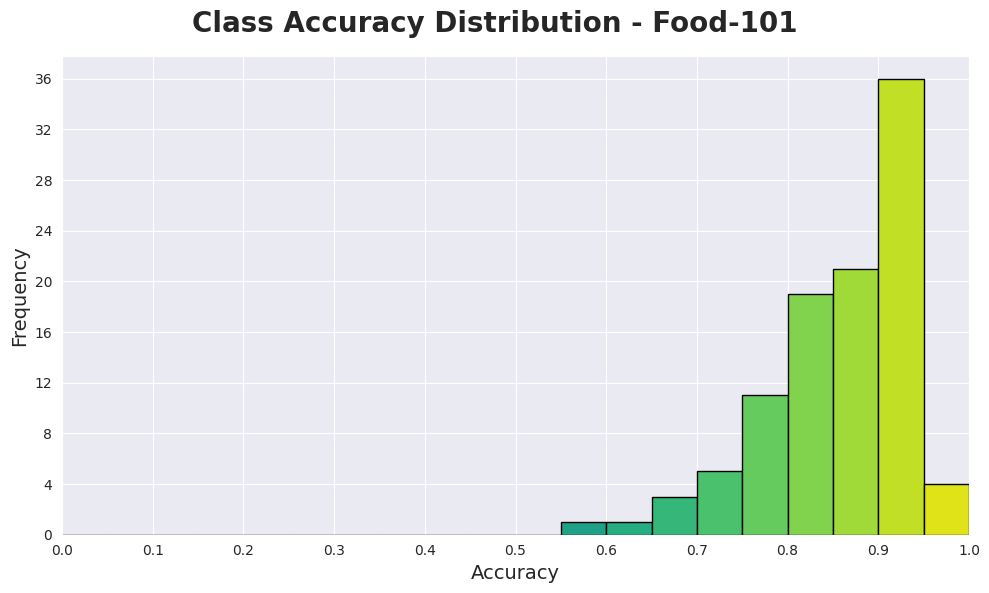

In [36]:
plot_per_class_accuracies(
    food101_per_class_acc,
    'Food-101',
    num_bins=20
)

#### FER2013

In [37]:
teacher_fer2013 = Backbone(model_names['RegNet'], num_classes=len(fer2013_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([7, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
get_model_params(teacher_fer2013)

Parameters: 80.59M


In [39]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    teacher_fer2013,
    fer2013_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 3589/3589 [08:46<00:00,  6.82it/s]


Epochs: 1/10 | train_loss: 1.1540 | train_acc: 0.5655


100%|██████████| 3589/3589 [08:45<00:00,  6.83it/s]


Epochs: 2/10 | train_loss: 0.7883 | train_acc: 0.7132


100%|██████████| 3589/3589 [08:41<00:00,  6.88it/s]


Epochs: 3/10 | train_loss: 0.4570 | train_acc: 0.8397


100%|██████████| 3589/3589 [08:46<00:00,  6.81it/s]


Epochs: 4/10 | train_loss: 0.2155 | train_acc: 0.9300


100%|██████████| 3589/3589 [08:46<00:00,  6.82it/s]


Epochs: 5/10 | train_loss: 0.1369 | train_acc: 0.9552


100%|██████████| 3589/3589 [08:48<00:00,  6.80it/s]


Epochs: 6/10 | train_loss: 0.1144 | train_acc: 0.9628


100%|██████████| 3589/3589 [08:45<00:00,  6.82it/s]


Epochs: 7/10 | train_loss: 0.0990 | train_acc: 0.9685


100%|██████████| 3589/3589 [08:44<00:00,  6.84it/s]


Epochs: 8/10 | train_loss: 0.0864 | train_acc: 0.9722


100%|██████████| 3589/3589 [08:43<00:00,  6.86it/s]


Epochs: 9/10 | train_loss: 0.0812 | train_acc: 0.9731


100%|██████████| 3589/3589 [08:48<00:00,  6.79it/s]

Epochs: 10/10 | train_loss: 0.0733 | train_acc: 0.9759


In [40]:
deit_fer2013 = Backbone(model_names['DeiT'], num_classes=len(fer2013_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
get_model_params(deit_fer2013)

Parameters: 85.81M


In [42]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = train_model(
    deit_fer2013,
    fer2013_train,
    config,
    'deit',
    use_val=False,
    fine_tune=True,
    with_distillation=True,
    teacher=teacher_fer2013,
)

100%|██████████| 3589/3589 [07:22<00:00,  8.11it/s]


Epochs: 1/10 | train_loss: 1.0280 | train_acc: 0.6186


100%|██████████| 3589/3589 [07:21<00:00,  8.13it/s]


Epochs: 2/10 | train_loss: 0.7231 | train_acc: 0.7366


100%|██████████| 3589/3589 [07:25<00:00,  8.06it/s]


Epochs: 3/10 | train_loss: 0.4458 | train_acc: 0.8445


100%|██████████| 3589/3589 [07:25<00:00,  8.05it/s]


Epochs: 4/10 | train_loss: 0.2071 | train_acc: 0.9330


100%|██████████| 3589/3589 [07:27<00:00,  8.03it/s]


Epochs: 5/10 | train_loss: 0.1091 | train_acc: 0.9654


100%|██████████| 3589/3589 [07:27<00:00,  8.01it/s]


Epochs: 6/10 | train_loss: 0.0913 | train_acc: 0.9712


100%|██████████| 3589/3589 [07:28<00:00,  8.01it/s]


Epochs: 7/10 | train_loss: 0.0754 | train_acc: 0.9768


100%|██████████| 3589/3589 [07:27<00:00,  8.02it/s]


Epochs: 8/10 | train_loss: 0.0714 | train_acc: 0.9782


100%|██████████| 3589/3589 [07:28<00:00,  8.00it/s]


Epochs: 9/10 | train_loss: 0.0668 | train_acc: 0.9790


100%|██████████| 3589/3589 [07:26<00:00,  8.04it/s]

Epochs: 10/10 | train_loss: 0.0567 | train_acc: 0.9817


In [43]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    deit_fer2013,
    fer2013_test,
    config
)

100%|██████████| 449/449 [00:15<00:00, 28.70it/s]

test_loss: 1.4609 | test_acc: 0.6982


In [44]:
fer2013_accs.append(fer2013_acc)

In [45]:
fer2013_per_class_acc

{'angry': 0.5906313645621182,
 'disgust': 0.7636363636363637,
 'fear': 0.5662878787878788,
 'happy': 0.8998862343572241,
 'sad': 0.5168350168350169,
 'surprise': 0.8028846153846154,
 'neutral': 0.707667731629393}

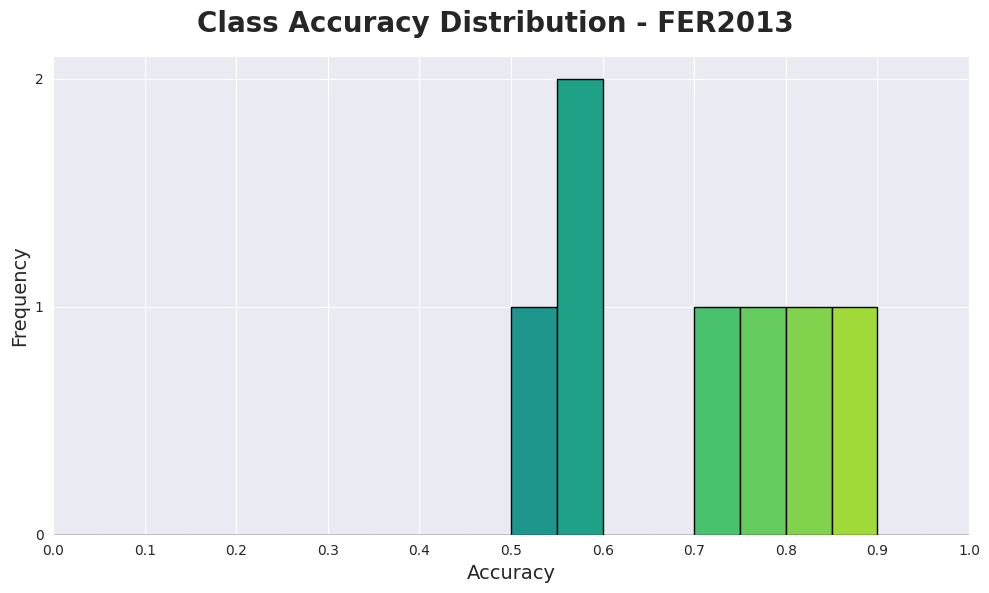

In [46]:
plot_per_class_accuracies(
    fer2013_per_class_acc,
    'FER2013',
    num_bins=20
)

#### PCam

In [47]:
teacher_pcam = Backbone(model_names['RegNet'], num_classes=len(pcam_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([2, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
get_model_params(teacher_pcam)

Parameters: 80.57M


In [49]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    teacher_pcam,
    pcam_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 32768/32768 [1:20:20<00:00,  6.80it/s]


Epochs: 1/10 | train_loss: 0.1780 | train_acc: 0.9316


100%|██████████| 32768/32768 [1:20:07<00:00,  6.82it/s]


Epochs: 2/10 | train_loss: 0.0958 | train_acc: 0.9659


100%|██████████| 32768/32768 [1:19:56<00:00,  6.83it/s]


Epochs: 3/10 | train_loss: 0.0613 | train_acc: 0.9785


100%|██████████| 32768/32768 [1:19:45<00:00,  6.85it/s]


Epochs: 4/10 | train_loss: 0.0426 | train_acc: 0.9846


100%|██████████| 32768/32768 [1:20:09<00:00,  6.81it/s]


Epochs: 5/10 | train_loss: 0.0333 | train_acc: 0.9883


100%|██████████| 32768/32768 [1:20:08<00:00,  6.81it/s]


Epochs: 6/10 | train_loss: 0.0274 | train_acc: 0.9901


100%|██████████| 32768/32768 [1:20:17<00:00,  6.80it/s]


Epochs: 7/10 | train_loss: 0.0240 | train_acc: 0.9915


100%|██████████| 32768/32768 [1:19:59<00:00,  6.83it/s]


Epochs: 8/10 | train_loss: 0.0218 | train_acc: 0.9921


100%|██████████| 32768/32768 [1:20:06<00:00,  6.82it/s]


Epochs: 9/10 | train_loss: 0.0197 | train_acc: 0.9930


100%|██████████| 32768/32768 [1:19:51<00:00,  6.84it/s]


Epochs: 10/10 | train_loss: 0.0181 | train_acc: 0.9935


In [50]:
deit_pcam = Backbone(model_names['DeiT'], num_classes=len(pcam_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
get_model_params(deit_pcam)

Parameters: 85.80M


In [52]:
pcam_loss, pcam_acc, pcam_per_class_acc = train_model(
    deit_pcam,
    pcam_train,
    config,
    'deit',
    use_val=False,
    fine_tune=True,
    with_distillation=True, 
    teacher=teacher_pcam,
)

100%|██████████| 32768/32768 [1:08:31<00:00,  7.97it/s]


Epochs: 1/10 | train_loss: 0.1334 | train_acc: 0.9516


100%|██████████| 32768/32768 [1:08:27<00:00,  7.98it/s]


Epochs: 2/10 | train_loss: 0.0675 | train_acc: 0.9775


100%|██████████| 32768/32768 [1:08:46<00:00,  7.94it/s]


Epochs: 3/10 | train_loss: 0.0414 | train_acc: 0.9867


100%|██████████| 32768/32768 [1:08:39<00:00,  7.95it/s]


Epochs: 4/10 | train_loss: 0.0293 | train_acc: 0.9904


100%|██████████| 32768/32768 [1:09:01<00:00,  7.91it/s]


Epochs: 5/10 | train_loss: 0.0235 | train_acc: 0.9924


100%|██████████| 32768/32768 [1:08:47<00:00,  7.94it/s]


Epochs: 6/10 | train_loss: 0.0205 | train_acc: 0.9936


100%|██████████| 32768/32768 [1:08:13<00:00,  8.01it/s]


Epochs: 7/10 | train_loss: 0.0181 | train_acc: 0.9941


100%|██████████| 32768/32768 [1:08:35<00:00,  7.96it/s]


Epochs: 8/10 | train_loss: 0.0172 | train_acc: 0.9945


100%|██████████| 32768/32768 [1:08:39<00:00,  7.95it/s]


Epochs: 9/10 | train_loss: 0.0161 | train_acc: 0.9951


100%|██████████| 32768/32768 [1:08:48<00:00,  7.94it/s]


Epochs: 10/10 | train_loss: 0.0152 | train_acc: 0.9951


In [53]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(
    deit_pcam,
    pcam_test,
    config
)

100%|██████████| 4096/4096 [02:26<00:00, 27.94it/s]

test_loss: 0.8239 | test_acc: 0.8385


In [54]:
pcam_accs.append(pcam_acc)

In [55]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9826124092489781,
 'lymph node tumor tissue': 0.6943274103926238}

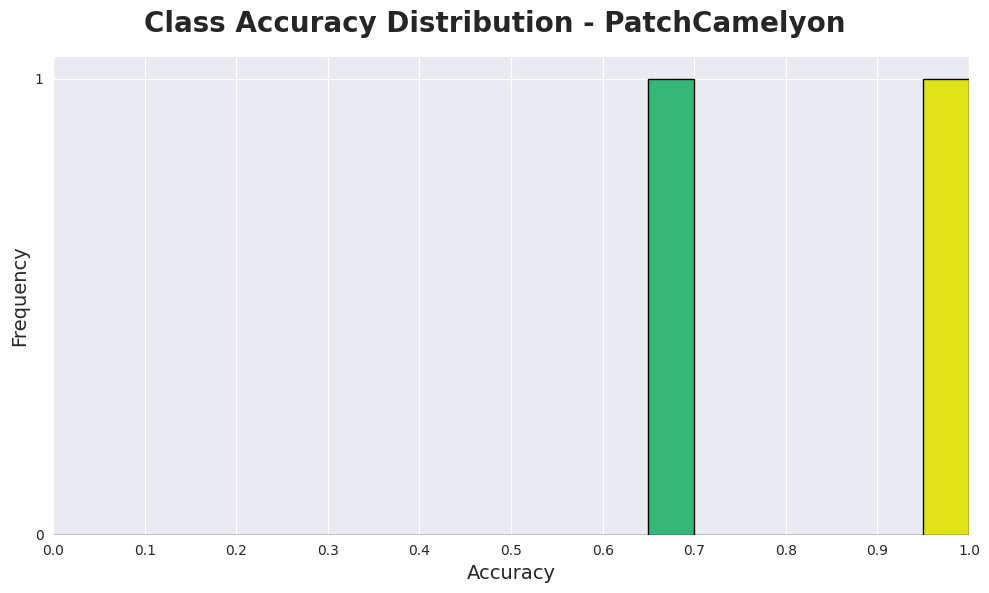

In [56]:
plot_per_class_accuracies(
    pcam_per_class_acc,
    'PatchCamelyon',
    num_bins=20
)

#### SUN397

In [57]:
teacher_sun397 = Backbone(model_names['RegNet'], num_classes=len(sun397_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([397, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(teacher_sun397)

Parameters: 81.77M


In [ ]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    teacher_sun397,
    sun397_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 9516/9516 [28:58<00:00,  5.47it/s]


Epochs: 1/10 | train_loss: 2.0552 | train_acc: 0.5183


100%|██████████| 9516/9516 [27:04<00:00,  5.86it/s] 


Epochs: 2/10 | train_loss: 0.9672 | train_acc: 0.7274


100%|██████████| 9516/9516 [27:17<00:00,  5.81it/s]


Epochs: 3/10 | train_loss: 0.5849 | train_acc: 0.8259


100%|██████████| 9516/9516 [27:18<00:00,  5.81it/s]


Epochs: 4/10 | train_loss: 0.3638 | train_acc: 0.8898


100%|██████████| 9516/9516 [27:11<00:00,  5.83it/s]


Epochs: 5/10 | train_loss: 0.2450 | train_acc: 0.9262


100%|██████████| 9516/9516 [27:11<00:00,  5.83it/s]


Epochs: 6/10 | train_loss: 0.1808 | train_acc: 0.9467


100%|██████████| 9516/9516 [27:17<00:00,  5.81it/s]


Epochs: 7/10 | train_loss: 0.1461 | train_acc: 0.9572


100%|██████████| 9516/9516 [27:14<00:00,  5.82it/s]


Epochs: 8/10 | train_loss: 0.1263 | train_acc: 0.9626


100%|██████████| 9516/9516 [27:11<00:00,  5.83it/s]


Epochs: 9/10 | train_loss: 0.1091 | train_acc: 0.9675


100%|██████████| 9516/9516 [27:14<00:00,  5.82it/s]


Epochs: 10/10 | train_loss: 0.0970 | train_acc: 0.9708


In [ ]:
deit_sun397 = Backbone(model_names['DeiT'], num_classes=len(sun397_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(deit_sun397)

Parameters: 86.41M


In [ ]:
sun397_loss, sun397_acc, sun397_per_class_acc = train_model(
    deit_sun397,
    sun397_train,
    config,
    'deit',
    use_val=False,
    fine_tune=True,
    with_distillation=True,
    teacher=teacher_sun397,
)

100%|██████████| 9516/9516 [23:45<00:00,  6.67it/s]


Epochs: 1/10 | train_loss: 1.8645 | train_acc: 0.5912


100%|██████████| 9516/9516 [23:55<00:00,  6.63it/s]


Epochs: 2/10 | train_loss: 0.6794 | train_acc: 0.8144


100%|██████████| 9516/9516 [23:54<00:00,  6.63it/s]


Epochs: 3/10 | train_loss: 0.3069 | train_acc: 0.9170


100%|██████████| 9516/9516 [23:57<00:00,  6.62it/s]


Epochs: 4/10 | train_loss: 0.1390 | train_acc: 0.9653


100%|██████████| 9516/9516 [24:01<00:00,  6.60it/s]


Epochs: 5/10 | train_loss: 0.0879 | train_acc: 0.9795


100%|██████████| 9516/9516 [23:55<00:00,  6.63it/s]


Epochs: 6/10 | train_loss: 0.0703 | train_acc: 0.9836


100%|██████████| 9516/9516 [24:03<00:00,  6.59it/s]


Epochs: 7/10 | train_loss: 0.0624 | train_acc: 0.9856


100%|██████████| 9516/9516 [24:08<00:00,  6.57it/s]


Epochs: 8/10 | train_loss: 0.0576 | train_acc: 0.9865


100%|██████████| 9516/9516 [23:56<00:00,  6.62it/s]


Epochs: 9/10 | train_loss: 0.0539 | train_acc: 0.9861


100%|██████████| 9516/9516 [23:49<00:00,  6.66it/s]


Epochs: 10/10 | train_loss: 0.0492 | train_acc: 0.9879


In [ ]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    deit_sun397,
    sun397_test,
    config
)

100%|██████████| 2719/2719 [02:52<00:00, 15.80it/s]


test_loss: 1.3168 | test_acc: 0.7211


In [ ]:
sun397_accs.append(sun397_acc)

In [ ]:
get_top_5_accuracies(sun397_per_class_acc)

[('raft', 1.0),
 ('wave', 1.0),
 ('underwater (coral reef)', 0.9913793103448276),
 ('bullring', 0.9666666666666667),
 ('stadium (football)', 0.9666666666666667)]

In [ ]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('bistro (indoor)', 0.10526315789473684),
 ('pub (indoor)', 0.12121212121212122),
 ('biology laboratory', 0.13636363636363635),
 ('recreation room', 0.14814814814814814),
 ('kitchenette', 0.15384615384615385)]

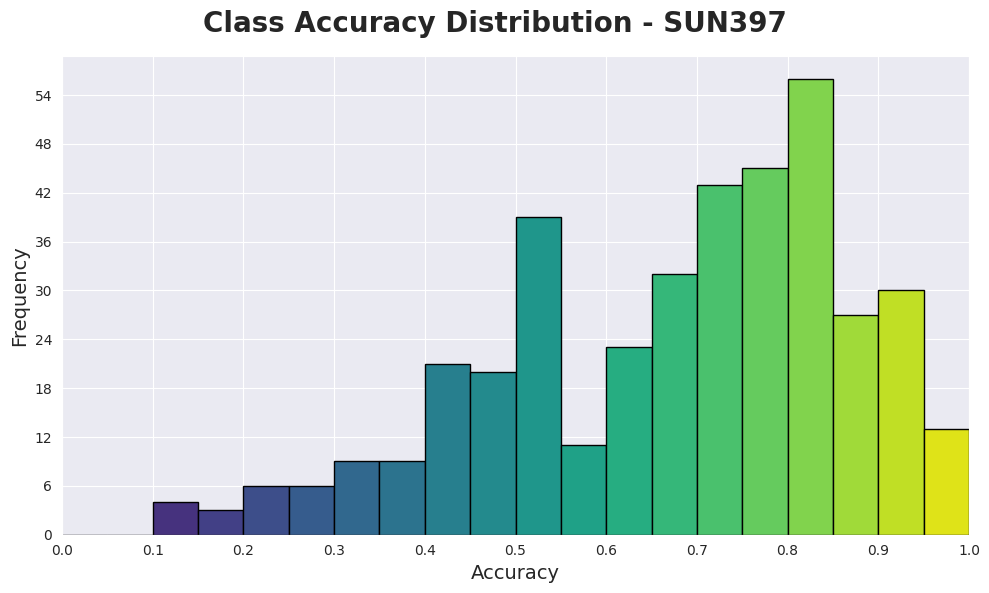

In [ ]:
plot_per_class_accuracies(
    sun397_per_class_acc,
    'SUN397',
    num_bins=20
)

#### DTD

In [ ]:
teacher_dtd = Backbone(model_names['RegNet'], num_classes=len(dtd_train.get_labels()))

Some weights of RegNetForImageClassification were not initialized from the model checkpoint at facebook/regnet-y-160 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 3024]) in the checkpoint and torch.Size([47, 3024]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(teacher_dtd)

Parameters: 80.71M


In [ ]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    teacher_dtd,
    dtd_train,
    config,
    'regnet',
    use_val=False,
    fine_tune=True,
)

100%|██████████| 470/470 [01:24<00:00,  5.55it/s]


Epochs: 1/10 | train_loss: 2.5202 | train_acc: 0.3875


100%|██████████| 470/470 [01:22<00:00,  5.68it/s]


Epochs: 2/10 | train_loss: 1.2598 | train_acc: 0.6545


100%|██████████| 470/470 [01:23<00:00,  5.64it/s]


Epochs: 3/10 | train_loss: 0.8455 | train_acc: 0.7582


100%|██████████| 470/470 [01:23<00:00,  5.63it/s]


Epochs: 4/10 | train_loss: 0.5704 | train_acc: 0.8354


100%|██████████| 470/470 [01:23<00:00,  5.66it/s]


Epochs: 5/10 | train_loss: 0.4054 | train_acc: 0.8867


100%|██████████| 470/470 [01:23<00:00,  5.63it/s]


Epochs: 6/10 | train_loss: 0.2761 | train_acc: 0.9255


100%|██████████| 470/470 [01:22<00:00,  5.71it/s]


Epochs: 7/10 | train_loss: 0.2339 | train_acc: 0.9362


100%|██████████| 470/470 [01:23<00:00,  5.64it/s]


Epochs: 8/10 | train_loss: 0.1513 | train_acc: 0.9577


100%|██████████| 470/470 [01:24<00:00,  5.55it/s]


Epochs: 9/10 | train_loss: 0.1332 | train_acc: 0.9654


100%|██████████| 470/470 [01:23<00:00,  5.65it/s]


Epochs: 10/10 | train_loss: 0.1167 | train_acc: 0.9702


In [ ]:
deit_dtd = Backbone(model_names['DeiT'], num_classes=len(dtd_train.get_labels()))

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
get_model_params(deit_dtd)

Parameters: 85.87M


In [ ]:
dtd_loss, dtd_acc, dtd_per_class_acc = train_model(
    deit_dtd,
    dtd_train,
    config,
    'deit',
    use_val=False,
    fine_tune=True,
    with_distillation=True,
    teacher=teacher_dtd,
)

100%|██████████| 470/470 [01:10<00:00,  6.66it/s]


Epochs: 1/10 | train_loss: 2.2478 | train_acc: 0.4955


100%|██████████| 470/470 [01:10<00:00,  6.66it/s]


Epochs: 2/10 | train_loss: 0.7192 | train_acc: 0.8423


100%|██████████| 470/470 [01:11<00:00,  6.55it/s]


Epochs: 3/10 | train_loss: 0.2689 | train_acc: 0.9612


100%|██████████| 470/470 [01:12<00:00,  6.44it/s]


Epochs: 4/10 | train_loss: 0.1129 | train_acc: 0.9872


100%|██████████| 470/470 [01:12<00:00,  6.48it/s]


Epochs: 5/10 | train_loss: 0.0631 | train_acc: 0.9888


100%|██████████| 470/470 [01:12<00:00,  6.50it/s]


Epochs: 6/10 | train_loss: 0.0633 | train_acc: 0.9907


100%|██████████| 470/470 [01:12<00:00,  6.53it/s]


Epochs: 7/10 | train_loss: 0.0507 | train_acc: 0.9872


100%|██████████| 470/470 [01:11<00:00,  6.59it/s]


Epochs: 8/10 | train_loss: 0.0441 | train_acc: 0.9888


100%|██████████| 470/470 [01:11<00:00,  6.56it/s]


Epochs: 9/10 | train_loss: 0.0427 | train_acc: 0.9883


100%|██████████| 470/470 [01:11<00:00,  6.58it/s]

Epochs: 10/10 | train_loss: 0.0428 | train_acc: 0.9880


In [ ]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(
    deit_dtd,
    dtd_test,
    config
)

100%|██████████| 235/235 [00:14<00:00, 16.14it/s]

test_loss: 0.8850 | test_acc: 0.7713


In [ ]:
dtd_accs.append(dtd_acc)

In [ ]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 1.0),
 ('knitted', 0.95),
 ('paisley', 0.95),
 ('studded', 0.95),
 ('cobwebbed', 0.925)]

In [ ]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('bumpy', 0.45),
 ('stained', 0.45),
 ('blotchy', 0.5),
 ('polka-dotted', 0.5),
 ('pitted', 0.525)]

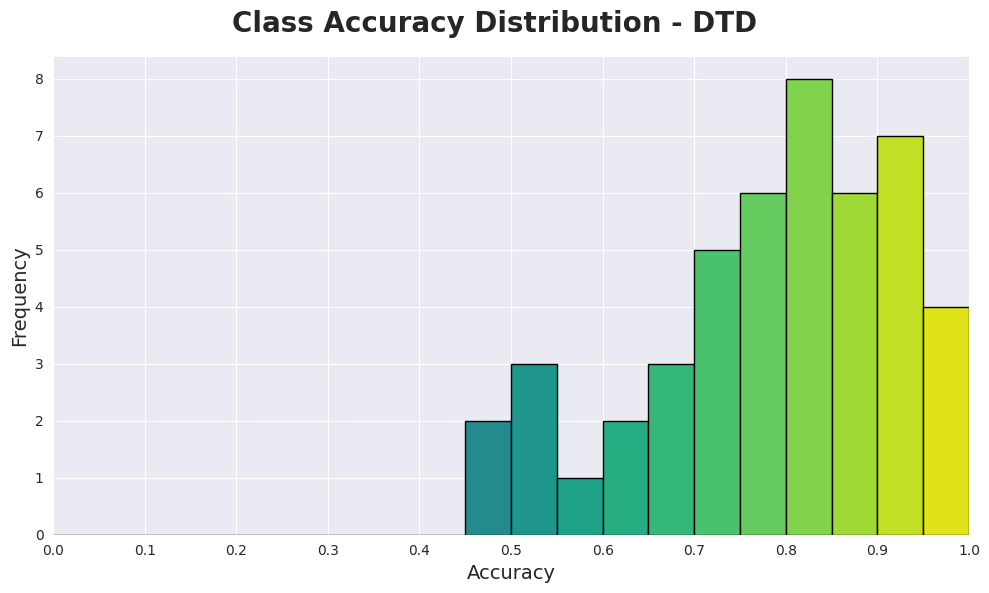

In [ ]:
plot_per_class_accuracies(
    dtd_per_class_acc,
    'DTD',
    num_bins=20
)

### Results

Display the results of the analysis in dataframe.

In [ ]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [ ]:
labels = ['RESISC45', 'Food-101', 'FER2013', 'PatchCamelyon', 'SUN397', 'DTD']

In [ ]:
acc_dict = create_accuracy_dict(
    results,
    labels
)

In [ ]:
df = pd.DataFrame(results, columns=['fine-tuning'], index=labels)
df

,fine-tuning
RESISC45,0.931429
Food-101,0.857505
FER2013,0.698245
PatchCamelyon,0.838531
SUN397,0.721149
DTD,0.771277
